In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# Symbolic for derivatives

In [2]:
# 1/2 case.
vi, bi, o = sp.symbols('v_i b_i o')

Q = bi**(1/2)*vi/(bi**(1/2) + o) - bi
Q

b_i**0.5*v_i/(b_i**0.5 + o) - b_i

In [4]:
sp.diff(Q, bi)

0.5*v_i/(b_i**0.5*(b_i**0.5 + o)) - 0.5*v_i/(b_i**0.5 + o)**2 - 1

In [6]:
xi = sp.symbols('x_i')
expr = 1/2 *(-1 + 1/xi)
sp.diff(expr, xi)

-0.5/x_i**2

In [7]:
# alpha > 1
vi, xi = sp.symbols('v_i x_i')
a      = sp.symbols('a')
y      = sp.symbols('y')


t1 = vi*xi*a * (xi**(1-1/a) - xi**(2-1/a))
t2 = sp.integrate(vi*y*((a-1)*y**(-1/a)-(2*a-1)*y**(1-1/a)), (y, 0, xi))
uhat = t1 - t2

In [18]:
sp.simplify(uhat.evalf(subs={a:1.0001}))

v_i*(1.000000009998*x_i**1.000099990001 - 0.500025001249813*x_i**2.000099990001)

In [19]:
sp.simplify(uhat.evalf(subs={a:2}))

v_i*(1.33333333333333*x_i**1.5 - 0.8*x_i**2.5)

In [17]:
sp.simplify(uhat.evalf(subs={a:2/3}))

v_i*(1.33333333333333*x_i**0.5 - 0.444444444444445*x_i**1.5)

In [103]:
# uhat prime
uhatprime = sp.diff(uhat, xi)
sp.simplify(uhatprime.evalf(subs={a:2}))

2.0*v_i*(x_i**0.5 - x_i**1.5)

In [104]:
# derive normal way
v1, v2, b1, b2 = sp.symbols('v_1 v_2 b_1 b_2')

u1 = v1*b1**2 / (b1**2 + b2**2) - b1
u2 = v2*b2**2 / (b1**2 + b2**2) - b2
u1

b_1**2*v_1/(b_1**2 + b_2**2) - b_1

In [105]:
part1 = sp.simplify(sp.diff(u1, b1))
part2 = sp.simplify(sp.diff(u2, b2))
part1

2*b_1*b_2**2*v_1/(b_1**2 + b_2**2)**2 - 1

In [106]:
foc1 = sp.Eq(part1, 0)
foc2 = sp.Eq(part2, 0)
foc1

Eq(2*b_1*b_2**2*v_1/(b_1**2 + b_2**2)**2 - 1, 0)

In [139]:
sol = sp.solve((foc1.evalf(subs={v1:2*(3**(1/2))}), foc2.evalf(subs={v2:2*(3**(1/2))})), (b1, b2), dict=True)
sol

[{b_1: 1.73205080756888, b_2: 1.73205080756888}]

In [132]:
sp.simplify(sp.diff(part2, b2)).evalf(subs={v2:2, b1:sol[0][b1], b2: sol[0][b2]})

-0.0864878831351132

In [119]:
part2.evalf(subs={v2:2, b1:sol[0][b1]})

2.37037037037037*b_2/(0.592592592592593*b_2**2 + 1.0)**2 - 1.0

In [97]:
part1.evalf(subs={v1:4, b2:16/25})

3.2768*b_1/(b_1**2 + 0.4096)**2 - 1.0

In [137]:
u2

b_2**2*v_2/(b_1**2 + b_2**2) - b_2

In [142]:
u1.evalf(subs={v1:2*(3**(1/2)), b2:sol[0][b2]})
u2.evalf(subs={v2:2*(3**(1/2)), b1:sol[0][b1]})

3.46410161513775*b_2**2/(b_2**2 + 3.0) - b_2

In [68]:
sp.simplify(sp.diff(part2, b2)).evalf(subs={v2:2, b1:1.28, b2:0.64})
sp.simplify(sp.diff(part1, b1)).evalf(subs={v1:4, b1:1.28, b2:0.64})

-1.71875000000000

# procurements, n=2, alpha=3

In [161]:
# derive normal way
c1, c2, v1, v2 = sp.symbols('c_1 c_2 v_1 v_2')

u1 = (c1-v1) * (1/c1)**3 / ((1/c1)**3 + (1/c2)**3)
u2 = (c2-v2) * (1/c2)**3 / ((1/c1)**3 + (1/c2)**3)
u1

(c_1 - v_1)/(c_1**3*(c_2**(-3) + c_1**(-3)))

In [167]:
sp.simplify(sp.diff(u1, c1))
sp.diff(u2, c2)

1/(c_2**3*(c_2**(-3) + c_1**(-3))) - 3*(c_2 - v_2)/(c_2**4*(c_2**(-3) + c_1**(-3))) + 3*(c_2 - v_2)/(c_2**7*(c_2**(-3) + c_1**(-3))**2)

In [168]:
part1 = sp.diff(u1, c1)
part2 = sp.diff(u2, c2)
foc1 = sp.Eq(part1, 0)
foc2 = sp.Eq(part2, 0)
foc1

Eq(1/(c_1**3*(c_2**(-3) + c_1**(-3))) - 3*(c_1 - v_1)/(c_1**4*(c_2**(-3) + c_1**(-3))) + 3*(c_1 - v_1)/(c_1**7*(c_2**(-3) + c_1**(-3))**2), 0)

In [184]:
dpart1 = sp.diff(part1, c1)
dpart2 = sp.diff(part2, c2)
print(sp.simplify(dpart1).evalf(subs={c1:9.66, c2:8.81, v1:4}))
print(sp.simplify(dpart2).evalf(subs={c1:9.66, c2:8.81, v2:2}))

-0.0893367120363459
-0.129079190932006


In [189]:
part1.evalf(subs={c1:9.66288, c2:8.81093, v1:4}), part2.evalf(subs={c1:9.66288, c2:8.81093, v2:2})

(-2.59570971620503e-7, 4.59836952919681e-7)

In [185]:
x, y = sp.symbols('x y')
print_latex(sp.simplify(foc1.evalf(subs={v1:4})).evalf(subs={c1:x, c2:y}))
print_latex(sp.simplify(foc2.evalf(subs={v2:2})).evalf(subs={c1:x, c2:y}))
sp.simplify(foc1.evalf(subs={v1:4})).evalf(subs={c1:x, c2:y})

\frac{y^{3} \left(- 2.0 x^{3} + 12.0 x^{2} + 1.0 y^{3}\right)}{1.0 x^{6} + 2.0 x^{3} y^{3} + 1.0 y^{6}} = 0
\frac{x^{3} \cdot \left(1.0 x^{3} - 2.0 y^{3} + 6.0 y^{2}\right)}{1.0 x^{6} + 2.0 x^{3} y^{3} + 1.0 y^{6}} = 0


Eq(y**3*(-2.0*x**3 + 12.0*x**2 + 1.0*y**3)/(1.0*x**6 + 2.0*x**3*y**3 + 1.0*y**6), 0)

In [ ]:
\frac{x^{3} \cdot \left(1.0 x^{3} - 2.0 y^{3} + 6.0 y^{2}\right)}{1.0 x^{6} + 2.0 x^{3} y^{3} + 1.0 y^{6}} = 0

In [172]:
sp.simplify(foc2.evalf(subs={v2:2}))

Eq(c_1**3*(1.0*c_1**3 - 2.0*c_2**3 + 6.0*c_2**2)/(1.0*c_1**6 + 2.0*c_1**3*c_2**3 + 1.0*c_2**6), 0)

In [190]:
sp.simplify(foc1.evalf(subs={v1:4}))

Eq(c_2**3*(-2.0*c_1**3 + 12.0*c_1**2 + 1.0*c_2**3)/(1.0*c_1**6 + 2.0*c_1**3*c_2**3 + 1.0*c_2**6), 0)

In [192]:
sp.simplify(foc2.evalf(subs={v2:2}))

Eq(c_1**3*(1.0*c_1**3 - 2.0*c_2**3 + 6.0*c_2**2)/(1.0*c_1**6 + 2.0*c_1**3*c_2**3 + 1.0*c_2**6), 0)

In [193]:
sol = sp.solve(
    (sp.simplify(foc1.evalf(subs={v1:4})), sp.simplify(foc2.evalf(subs={v2:2}))), 
    (c1, c2),
    dict=True)
sol

[]

In [212]:
# true values
v1, v2 = 4, 2

# init conditions
curr1, curr2 = 1, 1
a = 3

# symbols
c1 = sp.Symbol('c1', positive=True)
c2 = sp.Symbol('c2', positive=True)

p1Bids24, p2Bids24 = [curr1], [curr2]
turn = 0
for turn in tqdm(range(200)):
    if turn % 2 == 0:
        x1 = 1/(c1**a) / (1/(c1**a) + 1/(c2**a))
        u1 = (c1-v1)*x1
        partial = sp.diff(u1, c1)
        best = sp.Eq(partial, 0).evalf(subs={c2:curr2})
        sol = sp.solve(best)[0]
        curr1 = sol
        p1Bids24.append(curr1)
    else:
        x2 = 1/(c2**a) / (1/(c1**a) + 1/(c2**a))
        u2 = (c2-v2)*x2
        partial = sp.diff(u2, c2)
        best = sp.Eq(partial, 0).evalf(subs={c1:curr1})
        sol = sp.solve(best)[0]
        curr2 = sol
        p2Bids24.append(curr2)

100%|██████████| 200/200 [00:38<00:00,  5.15it/s]


In [213]:
p1Bids24[-1], p2Bids24[-1]

(9.66287914802542, 8.81093289882157)

In [214]:
1/(9.66287914802542**3) / (1/(9.66287914802542**3)+1/(8.81093289882157**3))

0.43121517662414144

In [216]:
1/(8.81093289882157**3) / (1/(9.66287914802542**3)+1/(8.81093289882157**3))

0.5687848233758587

In [281]:
# true values
v1, v2 = 4, 2

# init conditions
curr1, curr2 = 1, 1
a = 4

# symbols
c1 = sp.Symbol('c1', positive=True)
c2 = sp.Symbol('c2', positive=True)

p1Bids24, p2Bids24 = [curr1], [curr2]
turn = 0
for turn in tqdm(range(200)):
    if turn % 2 == 0:
        x1 = 1/(c1**a) / (1/(c1**a) + 1/(c2**a))
        u1 = (c1-v1)*x1
        partial = sp.diff(u1, c1)
        best = sp.Eq(partial, 0).evalf(subs={c2:curr2})
        sol = sp.solve(best)[0]
        curr1 = sol
        p1Bids24.append(curr1)
    else:
        x2 = 1/(c2**a) / (1/(c1**a) + 1/(c2**a))
        u2 = (c2-v2)*x2
        partial = sp.diff(u2, c2)
        best = sp.Eq(partial, 0).evalf(subs={c1:curr1})
        sol = sp.solve(best)[0]
        curr2 = sol
        p2Bids24.append(curr2)

  8%|▊         | 15/200 [00:08<01:40,  1.84it/s]


KeyboardInterrupt: 

In [213]:
p1Bids24[-1], p2Bids24[-1]

(9.66287914802542, 8.81093289882157)

In [214]:
1/(9.66287914802542**3) / (1/(9.66287914802542**3)+1/(8.81093289882157**3))

0.43121517662414144

In [216]:
1/(8.81093289882157**3) / (1/(9.66287914802542**3)+1/(8.81093289882157**3))

0.5687848233758587

In [154]:
# derive normal way
ci, vi, o= sp.symbols('c_i v_i o')

q = (ci-vi)*(1/ci**3) / (1/ci**3 + o)
q

(c_i - v_i)/(c_i**3*(o + c_i**(-3)))

In [158]:
print_latex(sp.diff(q, ci))
sp.diff(q, ci)

\frac{1}{c_{i}^{3} \left(o + \frac{1}{c_{i}^{3}}\right)} - \frac{3 \left(c_{i} - v_{i}\right)}{c_{i}^{4} \left(o + \frac{1}{c_{i}^{3}}\right)} + \frac{3 \left(c_{i} - v_{i}\right)}{c_{i}^{7} \left(o + \frac{1}{c_{i}^{3}}\right)^{2}}


1/(c_i**3*(o + c_i**(-3))) - 3*(c_i - v_i)/(c_i**4*(o + c_i**(-3))) + 3*(c_i - v_i)/(c_i**7*(o + c_i**(-3))**2)

In [ ]:
t1 = -vi*xi*a * (xi**(1-1/a) - xi**(2-1/a))
t2 = sp.integrate(vi*y*((a-1)*y**(-1/a)-(2*a-1)*y**(1-1/a)), (y, 0, xi))
uhat = t1 - t2

# procurements 

In [290]:
# derive normal way
a, xi = sp.symbols('a x_i')
y     = sp.symbols('y')

expr = a*y**(1/a)*(1-y) / (a-a*y-1)
expr

a*y**(1/a)*(1 - y)/(-a*y + a - 1)

In [291]:
print_latex(sp.diff(expr, y))
integrand = sp.diff(expr, y)
integrand
sp.simplify(integrand)

\frac{a^{2} y^{\frac{1}{a}} \left(1 - y\right)}{\left(- a y + a - 1\right)^{2}} - \frac{a y^{\frac{1}{a}}}{- a y + a - 1} + \frac{y^{\frac{1}{a}} \left(1 - y\right)}{y \left(- a y + a - 1\right)}


(a**2*y**((a + 1)/a)*(1 - y) + a*y**((a + 1)/a)*(a*y - a + 1) + y**(1/a)*(y - 1)*(a*y - a + 1))/(y*(a*y - a + 1)**2)

In [292]:
t1 = -vi*xi*a*(xi**(1/a) *(1-xi)) / (a-a*xi-1)
t2 = sp.integrate(-vi*y*(sp.simplify(integrand)), (y, 0, xi))
t2

-v_i*(Integral(-y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1 + 1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(-2*a*y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**2*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)))

In [294]:
uhat = t1 - t2
uhat

-a*v_i*x_i*x_i**(1/a)*(1 - x_i)/(-a*x_i + a - 1) + v_i*(Integral(-y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1 + 1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(-2*a*y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**2*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)))

In [305]:
sp.simplify(uhat.evalf(subs={a:2.999999999}))

v_i*(-2.999999999*x_i**1.33333333344444*(x_i - 1.0) + (2.999999999*x_i - 1.999999999)*(0.166666666722222*Integral(y**0.333333333444444/(0.750000000125*y**2 - 1.0*y + 0.333333333277778), (y, 0, x_i)) - 0.166666666722222*Integral(y**1.33333333344444/(0.750000000125*y**2 - 1.0*y + 0.333333333277778), (y, 0, x_i)) + 0.250000000125*Integral(y**2.33333333344444/(0.750000000125*y**2 - 1.0*y + 0.333333333277778), (y, 0, x_i))))/(2.999999999*x_i - 1.999999999)

In [344]:
# two player, v1=4, v2=2, a=3
uhat1 = uhat.evalf(subs={a:2.9999999999999999, vi:4})
uhat2 = uhat.evalf(subs={a:2.9999999999999999, vi:2})
uhat2

-6.0*x_i**1.33333333333333*(1.0 - x_i)/(2.0 - 3.0*x_i) + 2.0*Integral(-y**0.333333333333333/(9.0*y**2 - 12.0*y + 4.0), (y, 0, x_i)) + 2.0*Integral(3.0*y**0.333333333333333/(9.0*y**2 - 12.0*y + 4.0), (y, 0, x_i)) + 2.0*Integral(-6.0*y**1.33333333333333/(9.0*y**2 - 12.0*y + 4.0), (y, 0, x_i)) + 2.0*Integral(y**1.33333333333333/(9.0*y**2 - 12.0*y + 4.0), (y, 0, x_i)) + 2.0*Integral(3.0*y**1.33333333333333/(9.0*y**2 - 12.0*y + 4.0), (y, 0, x_i)) + 2.0*Integral(3.0*y**2.33333333333333/(9.0*y**2 - 12.0*y + 4.0), (y, 0, x_i))

In [345]:
testX = 0.43
sumhats = uhat1.evalf(subs={xi:testX}) + uhat2.evalf(subs={xi:1-testX})
sumhats

-3.41183194590359

In [351]:
res = []
candidates = np.arange(0.43, 0.432, 0.0001)
for testX in tqdm(candidates):
    res.append(uhat1.evalf(subs={xi:testX}) + uhat2.evalf(subs={xi:1-testX}))
res = np.array(res)

100%|██████████| 21/21 [01:09<00:00,  3.30s/it]


In [347]:
res, candidates[np.argmax(res)]

(array([-3.46106416126206, -3.46036919871258, -3.45968026498791,
        -3.45899733001306, -3.45832036399166, -3.45764933740268,
        -3.45698422099724, -3.45632498579546, -3.45567160308326,
        -3.45502404440938, -3.45438228158225, -3.45374628666709,
        -3.45311603198292, -3.45249149009965, -3.45187263383525,
        -3.45125943625290, -3.45065187065825, -3.45004991059663,
        -3.44945352985042, -3.44886270243631, -3.44827740260275,
        -3.44769760482730, -3.44712328381414, -3.44655441449151,
        -3.44599097200926, -3.44543293173641, -3.44488026925869,
        -3.44433296037625, -3.44379098110124, -3.44325430765555,
        -3.44272291646850, -3.44219678417463, -3.44167588761143,
        -3.44116020381720, -3.44064971002891, -3.44014438368000,
        -3.43964420239837, -3.43914914400424, -3.43865918650815,
        -3.43817430810896, -3.43769448719181, -3.43721970232622,
        -3.43674993226411, -3.43628515593793, -3.43582535245875,
        -3.43537050111444

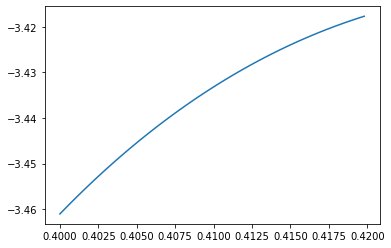

In [349]:
plt.plot(candidates, res)

In [269]:
# derive normal way
a, xi = sp.symbols('a x_i')
y     = sp.symbols('y')

expr = a*y**(1/a)*(1-y) / (a-a*y-1)
expr

a*y**(1/a)*(1 - y)/(-a*y + a - 1)

In [270]:
print_latex(sp.diff(expr, y))
integrand = sp.diff(expr, y)
integrand
sp.simplify(integrand)

\frac{a^{2} y^{\frac{1}{a}} \left(1 - y\right)}{\left(- a y + a - 1\right)^{2}} - \frac{a y^{\frac{1}{a}}}{- a y + a - 1} + \frac{y^{\frac{1}{a}} \left(1 - y\right)}{y \left(- a y + a - 1\right)}


(a**2*y**((a + 1)/a)*(1 - y) + a*y**((a + 1)/a)*(a*y - a + 1) + y**(1/a)*(y - 1)*(a*y - a + 1))/(y*(a*y - a + 1)**2)

In [271]:
t1 = vi*xi*a*(xi**(1/a) *(1-xi)) / (a-a*xi-1)
t2 = sp.integrate(vi*y*(sp.simplify(integrand)), (y, 0, xi))
t2

v_i*(Integral(-y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1 + 1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(-2*a*y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**2*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)))

In [272]:
uhat = t1 - t2
uhat

a*v_i*x_i*x_i**(1/a)*(1 - x_i)/(-a*x_i + a - 1) - v_i*(Integral(-y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1 + 1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(-2*a*y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**2*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)))

In [273]:
sp.simplify(uhat.evalf(subs={a:1}))

1.0*v_i*(x_i**2/2 - x_i)

In [274]:
# two player, v1=4, v2=2, a=2.5
uhat1 = uhat.evalf(subs={a:2.5, vi:4})
uhat2 = uhat.evalf(subs={a:2.5, vi:2})
uhat2

5.0*x_i**1.4*(1.0 - x_i)/(1.5 - 2.5*x_i) - 2.0*Integral(-y**0.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) - 2.0*Integral(2.5*y**0.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) - 2.0*Integral(-5.0*y**1.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) - 2.0*Integral(y**1.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) - 2.0*Integral(2.5*y**1.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) - 2.0*Integral(2.5*y**2.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i))

In [275]:
testX = 0.45
sumhats = uhat1.evalf(subs={xi:testX}) + uhat2.evalf(subs={xi:1-testX})
sumhats

4.13010937117973

In [276]:
res = []
for testX in tqdm(np.arange(0.44, 0.48, 0.001)):
    res.append(uhat1.evalf(subs={xi:testX}) + uhat2.evalf(subs={xi:1-testX}))
res = np.array(res)

100%|██████████| 40/40 [01:51<00:00,  2.78s/it]


In [277]:
res

array([4.18335669265438, 4.17622007724929, 4.16952771063106,
       4.16326197988870, 4.15740654456487, 4.15194622370708,
       4.14686689537999, 4.14215540703224, 4.13779949534804,
       4.13378771441180, 4.13010937117973, 4.12675446739196,
       4.12371364717673, 4.12097814969796, 4.11853976628256,
       4.11639080153642, 4.11452403802000, 4.11293270410766,
       4.11161044470096, 4.11055129450544, 4.10974965361500,
       4.10920026517749, 4.10889819494122, 4.10883881250443,
       4.10901777410989, 4.10943100684355, 4.11007469411205,
       4.11094526228660, 4.11203936841298, 4.11335388889773,
       4.11488590908981, 4.11663271368514, 4.11859177788899,
       4.12076075927738, 4.12313749030466, 4.12571997140960,
       4.12850636467695, 4.13149498801560, 4.13468430981844,
       4.13807294407198], dtype=object)

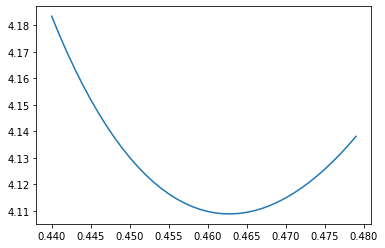

In [278]:
plt.plot(np.arange(0.44, 0.48, 0.001), res)

In [221]:
# derive normal way
a, xi = sp.symbols('a x_i')
y     = sp.symbols('y')

expr = a*y**(1/a)*(1-y) / (a-a*y-1)
expr

a*y**(1/a)*(1 - y)/(-a*y + a - 1)

In [226]:
print_latex(sp.diff(expr, y))
integrand = sp.diff(expr, y)
integrand
sp.simplify(integrand)

\frac{a^{2} y^{\frac{1}{a}} \left(1 - y\right)}{\left(- a y + a - 1\right)^{2}} - \frac{a y^{\frac{1}{a}}}{- a y + a - 1} + \frac{y^{\frac{1}{a}} \left(1 - y\right)}{y \left(- a y + a - 1\right)}


(a**2*y**((a + 1)/a)*(1 - y) + a*y**((a + 1)/a)*(a*y - a + 1) + y**(1/a)*(y - 1)*(a*y - a + 1))/(y*(a*y - a + 1)**2)

In [227]:
t1 = -vi*xi*a*(xi**(1/a) *(1-xi)) / (a-a*xi-1)
t2 = sp.integrate(-vi*y*(sp.simplify(integrand)), (y, 0, xi))
t2

-v_i*(Integral(-y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1 + 1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(-2*a*y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**2*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)))

In [233]:
uhat = t1 - t2
uhat

-a*v_i*x_i*x_i**(1/a)*(1 - x_i)/(-a*x_i + a - 1) + v_i*(Integral(-y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**(1 + 1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(-2*a*y*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)) + Integral(a*y**2*y**(1/a)/(a**2*y**2 - 2*a**2*y + a**2 + 2*a*y - 2*a + 1), (y, 0, x_i)))

In [232]:
sp.simplify(uhat.evalf(subs={a:1}))

1.0*v_i*(-x_i**2/2 + x_i)

In [245]:
# two player, v1=4, v2=2, a=2.5
uhat1 = uhat.evalf(subs={a:2.5, vi:4})
uhat2 = uhat.evalf(subs={a:2.5, vi:2})
uhat2

-5.0*x_i**1.4*(1.0 - x_i)/(1.5 - 2.5*x_i) + 2.0*Integral(-y**0.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) + 2.0*Integral(2.5*y**0.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) + 2.0*Integral(-5.0*y**1.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) + 2.0*Integral(y**1.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) + 2.0*Integral(2.5*y**1.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i)) + 2.0*Integral(2.5*y**2.4/(6.25*y**2 - 7.5*y + 2.25), (y, 0, x_i))

In [263]:
testX = 0.45
sumhats = uhat1.evalf(subs={xi:testX}) + uhat2.evalf(subs={xi:1-testX})
sumhats

-4.13010937117973

In [265]:
res = []
for testX in tqdm(np.arange(0.44, 0.48, 0.001)):
    res.append(uhat1.evalf(subs={xi:testX}) + uhat2.evalf(subs={xi:1-testX}))
res = np.array(res)

100%|██████████| 40/40 [01:51<00:00,  2.79s/it]


In [266]:
res

array([-4.18335669265438, -4.17622007724929, -4.16952771063106,
       -4.16326197988870, -4.15740654456487, -4.15194622370708,
       -4.14686689537999, -4.14215540703224, -4.13779949534804,
       -4.13378771441180, -4.13010937117973, -4.12675446739196,
       -4.12371364717673, -4.12097814969796, -4.11853976628256,
       -4.11639080153642, -4.11452403802000, -4.11293270410766,
       -4.11161044470096, -4.11055129450544, -4.10974965361500,
       -4.10920026517749, -4.10889819494122, -4.10883881250443,
       -4.10901777410989, -4.10943100684355, -4.11007469411205,
       -4.11094526228660, -4.11203936841298, -4.11335388889773,
       -4.11488590908981, -4.11663271368514, -4.11859177788899,
       -4.12076075927738, -4.12313749030466, -4.12571997140960,
       -4.12850636467695, -4.13149498801560, -4.13468430981844,
       -4.13807294407198], dtype=object)

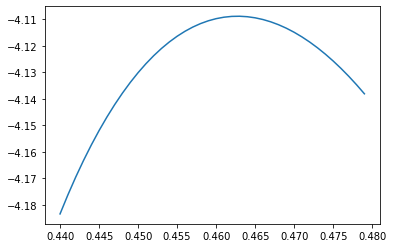

In [268]:
plt.plot(np.arange(0.44, 0.48, 0.001), res)

In [ ]:
t1 = vi*xi*a * (xi**(1-1/a) - xi**(2-1/a))
t2 = sp.integrate(vi*y*((a-1)*y**(-1/a)-(2*a-1)*y**(1-1/a)), (y, 0, xi))
uhat = t1 - t2

In [6]:
# 1/2 case.
vi, xi = sp.symbols('v_i x_i')
y      = sp.symbols('y')


t1 = vi*xi*a * (xi**(1-1/a) - xi**(2-1/a))
t2 = sp.integrate(vi*y*((a-1)*y**(-1/a)-(2*a-1)*y**(1-1/a)), (y, 0, xi))
uhat = t1 - t2

In [9]:
uhat.evalf(subs={a:1/2+0.1})
uhat

a*v_i*x_i*(x_i**(1 - 1/a) - x_i**(2 - 1/a)) - Piecewise((v_i*(log(x_i)/3 + 2/(3*x_i)) - oo*sign(v_i), Eq(a, 1/3)), (-v_i*log(x_i)/2 - oo*sign(v_i), Eq(a, 1/2)), (v_i*(-4*a**3*x_i**2*x_i**(1/a)*x_i**(1 - 1/a)/(6*a**2*x_i**(1/a) - 5*a*x_i**(1/a) + x_i**(1/a)) + 3*a**3*x_i**2/(6*a**2*x_i**(1/a) - 5*a*x_i**(1/a) + x_i**(1/a)) + 4*a**2*x_i**2*x_i**(1/a)*x_i**(1 - 1/a)/(6*a**2*x_i**(1/a) - 5*a*x_i**(1/a) + x_i**(1/a)) - 4*a**2*x_i**2/(6*a**2*x_i**(1/a) - 5*a*x_i**(1/a) + x_i**(1/a)) - a*x_i**2*x_i**(1/a)*x_i**(1 - 1/a)/(6*a**2*x_i**(1/a) - 5*a*x_i**(1/a) + x_i**(1/a)) + a*x_i**2/(6*a**2*x_i**(1/a) - 5*a*x_i**(1/a) + x_i**(1/a))), True))